In [1]:
# k crossover d，close > ema 8, ema 8 > ema 18, ema 18 > 38, take profit atr, stop loss atr
# Variables :
# time - 15m, 1h
# start time - 1609492611000, 1641028611000, 1672564611000 (2021, 2022, 2023)
# tp atr - 4, 6
# sl atr - 3, 5
# sl - Close, Low

In [2]:
# ! conda install -c conda-forge ta --yes

In [3]:
import requests
import pandas as pd
import ta
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import time

In [4]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '15m'

# start epoch till now
start_time = 1651366861000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600

In [5]:
pro_per = 0.03
sl_atr = 0.05

In [6]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    rawdf = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        rawdf = pd.concat([rawdf, out], axis = 0)
    
    rawdf = rawdf[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    rawdf = rawdf.astype(convert_dict)
    
    rawdf['Close_Time'] = pd.to_datetime(rawdf['Close_Time'], unit = 'ms')
    rawdf['Close_Time'] = rawdf['Close_Time'] + pd.Timedelta(hours=timezone)
    rawdf['Close_Time'] = rawdf['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    rawdf = rawdf.reset_index(drop=True)
    
    return rawdf

In [7]:
rawdf = get_historical(symbol, interval, start_time, end_time, step)
print(rawdf)

                Close_Time     Open    Close     High      Low      Volume
0      2022-05-01 09:29:59  2738.40  2738.36  2742.95  2734.26   3623.6520
1      2022-05-01 09:44:59  2738.36  2768.97  2772.00  2725.40  11211.8237
2      2022-05-01 09:59:59  2768.97  2770.25  2777.36  2762.01   9232.8878
3      2022-05-01 10:14:59  2770.26  2773.27  2776.22  2765.86   4203.3607
4      2022-05-01 10:29:59  2773.27  2771.35  2780.62  2769.65   5154.4383
...                    ...      ...      ...      ...      ...         ...
32664  2023-04-06 16:44:59  1876.38  1881.51  1883.87  1876.38   5143.7418
32665  2023-04-06 16:59:59  1881.50  1879.66  1882.41  1879.29   2062.2746
32666  2023-04-06 17:14:59  1879.65  1881.21  1881.22  1879.27   2355.6771
32667  2023-04-06 17:29:59  1881.21  1883.44  1885.50  1881.01   2835.9653
32668  2023-04-06 17:44:59  1883.45  1883.00  1883.45  1882.84    150.2581

[32669 rows x 6 columns]


In [8]:
df = rawdf.copy()

In [9]:
def check_cross(df, kd_dir):
    up = df['slow_k'] > df['slow_d']
    down = df['slow_k'] < df['slow_d']
    if kd_dir == 'Up':
        return up.diff() & up
    if kd_dir == 'Any':
        return up.diff()
    if kd_dir == 'Down':
        return down.diff() & down


def indicators(df):

# ema
    for i in (8, 18, 38):
        df['ema_'+str(i)] = ta.trend.ema_indicator(df.Close, window=i)
        
#     bband
    bb_int = 30
    bb_dev = 2
    bb = ta.volatility.BollingerBands(df['Close'], window=bb_int, window_dev=bb_dev)
    df['bb_u'] = bb.bollinger_hband()
    df['bb_m'] = bb.bollinger_mavg()
    df['bb_l'] = bb.bollinger_lband()        

# atr
    df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)
    
# rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()

# kd
    kd_int = 14
    d_int = 3
   
    kd_df = pd.DataFrame()
    kd_df[str(kd_int) + '-Low'] = df['Low'].rolling(kd_int).min()
    kd_df[str(kd_int) + '-High'] = df['High'].rolling(kd_int).max()
    df['slow_k'] = (df['Close'] - kd_df[str(kd_int) + '-Low'])*100/(kd_df[str(kd_int) + '-High'] - kd_df[str(kd_int) + '-Low'])
    df['slow_d'] = df['slow_k'].rolling(d_int).mean()
    
# kd cross
#     df['kd_cross'] = check_cross(df, kd_dir)

In [10]:
indicators(df)
print(df)

                Close_Time     Open    Close     High      Low      Volume  \
0      2022-05-01 09:29:59  2738.40  2738.36  2742.95  2734.26   3623.6520   
1      2022-05-01 09:44:59  2738.36  2768.97  2772.00  2725.40  11211.8237   
2      2022-05-01 09:59:59  2768.97  2770.25  2777.36  2762.01   9232.8878   
3      2022-05-01 10:14:59  2770.26  2773.27  2776.22  2765.86   4203.3607   
4      2022-05-01 10:29:59  2773.27  2771.35  2780.62  2769.65   5154.4383   
...                    ...      ...      ...      ...      ...         ...   
32664  2023-04-06 16:44:59  1876.38  1881.51  1883.87  1876.38   5143.7418   
32665  2023-04-06 16:59:59  1881.50  1879.66  1882.41  1879.29   2062.2746   
32666  2023-04-06 17:14:59  1879.65  1881.21  1881.22  1879.27   2355.6771   
32667  2023-04-06 17:29:59  1881.21  1883.44  1885.50  1881.01   2835.9653   
32668  2023-04-06 17:44:59  1883.45  1883.00  1883.45  1882.84    150.2581   

             ema_8       ema_18       ema_38         bb_u      

In [11]:
def conditions(df):

    for index, row in df.iterrows():
        # c1
        df['c1'] = df['High'] <= df['bb_m']
        # c2
        df['c2'] = df['Close'] > df['Open']
        # c3
        df['c3'] = df['Volume'] >= df['Volume'].shift(1)

        df['c4'] = df['Close'].shift(1) < df['Open'].shift(1)

    # 條件達成
    df['signal'] = False
    df.loc[df.c1 & df.c2 & df.c3 & df.c4, 'signal'] = True


    # 下一根進場
    df['open_entry'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'open_entry'] = True
#     print(df[df['Close_Time'].str.contains('2023-03-11 16')])
    
    return df

In [12]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,ema_8,ema_18,ema_38,bb_u,...,atr,rsi,slow_k,slow_d,c1,c2,c3,c4,signal,open_entry
0,2022-05-01 09:29:59,2738.40,2738.36,2742.95,2734.26,3623.6520,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,False,False,False,False,False,False
1,2022-05-01 09:44:59,2738.36,2768.97,2772.00,2725.40,11211.8237,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,False,True,True,True,False,False
2,2022-05-01 09:59:59,2768.97,2770.25,2777.36,2762.01,9232.8878,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,False,True,False,False,False,False
3,2022-05-01 10:14:59,2770.26,2773.27,2776.22,2765.86,4203.3607,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,False,True,False,False,False,False
4,2022-05-01 10:29:59,2773.27,2771.35,2780.62,2769.65,5154.4383,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32664,2023-04-06 16:44:59,1876.38,1881.51,1883.87,1876.38,5143.7418,1882.794440,1886.875994,1892.003993,1903.386138,...,5.637964,38.716359,47.085762,37.288302,True,True,True,True,True,False
32665,2023-04-06 16:59:59,1881.50,1879.66,1882.41,1879.29,2062.2746,1882.097898,1886.116416,1891.370967,1903.585478,...,5.458109,36.806362,41.255997,37.938336,True,False,False,False,False,True
32666,2023-04-06 17:14:59,1879.65,1881.21,1881.22,1879.27,2355.6771,1881.900587,1885.599951,1890.849892,1903.354834,...,5.207530,39.499400,48.015700,45.452486,True,True,True,True,True,False
32667,2023-04-06 17:29:59,1881.21,1883.44,1885.50,1881.01,2835.9653,1882.242679,1885.372588,1890.469898,1902.700102,...,5.156278,43.246696,57.740951,49.004216,True,True,True,False,False,True


In [13]:
entry_df = conditions(df).copy()

in_position = False
stop_loss = np.nan
take_profit = np.nan
close_val = entry_df['Close']
low_val = entry_df['Low']
atr_val = entry_df['atr']


for index, row in entry_df.iterrows():

    if index == 0:
        continue
    
    elif entry_df.at[index, 'open_entry'] == True:
   
        entry_df.at[index, 'entry_p'] = close_val.shift(1).at[index]
        entry_df.at[index, 'stop_loss'] = low_val.shift(1).at[index]
        entry_df.at[index, 'take_profit'] = close_val.shift(1).at[index] * (1 + pro_per/10)
        entry_df.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = entry_df.at[index, 'stop_loss']
        take_profit = entry_df.at[index, 'take_profit']
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and (entry_df.at[index, 'Close'] <= stop_loss):
        entry_df.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan
        take_profit = np.nan

    # set take profit
    elif in_position == True and (entry_df.at[index, 'High'] >= take_profit):
        entry_df.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan
        take_profit = np.nan
        
entry_df.to_csv('entry_df.csv')
        
raw_entry_df = entry_df.copy()

# 過濾有訊號或事件發生的Ｋ線
entry_df = entry_df[(entry_df['open_entry'] == True) |
              (entry_df['signal'] == True) | 
              (entry_df['position'] == 'Buy') |
              (entry_df['position'] == 'Sell') |
              (entry_df['position'] == 'Stop')]

print(entry_df)

                Close_Time     Open    Close     High      Low     Volume  \
38     2022-05-01 18:59:59  2766.25  2766.42  2772.12  2761.00  2147.5739   
39     2022-05-01 19:14:59  2766.42  2761.66  2767.59  2760.97  1455.1082   
40     2022-05-01 19:29:59  2761.66  2762.68  2769.30  2751.74  4332.4912   
41     2022-05-01 19:44:59  2762.67  2758.14  2763.90  2755.41  2697.5501   
43     2022-05-01 20:14:59  2756.79  2760.11  2779.42  2753.50  7149.9979   
...                    ...      ...      ...      ...      ...        ...   
32663  2023-04-06 16:29:59  1879.94  1876.39  1879.94  1874.43  4625.2598   
32664  2023-04-06 16:44:59  1876.38  1881.51  1883.87  1876.38  5143.7418   
32665  2023-04-06 16:59:59  1881.50  1879.66  1882.41  1879.29  2062.2746   
32666  2023-04-06 17:14:59  1879.65  1881.21  1881.22  1879.27  2355.6771   
32667  2023-04-06 17:29:59  1881.21  1883.44  1885.50  1881.01  2835.9653   

             ema_8       ema_18       ema_38         bb_u  ...     c1     c

In [14]:
# 部位回測

pos_df = entry_df.copy()
pos_df = pos_df.reset_index(drop = True)
pos_df = pos_df[(pos_df['position'] == 'Buy') |
              (pos_df['position'] == 'Sell') |
              (pos_df['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'Volume', 'bb_l', 'position','entry_p', 'stop_loss', 'take_profit']
pos = pos_df[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：達成條件時收盤價
        if pos.at[index, 'position'] == 'Sell':
#             pos.at[index, 'exit_p'] = pos.at[index, 'Close']
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'take_profit']
                break

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break


# 手續費、滑點、價差
fee = 0.05 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee


# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算獲利/虧損次數
agg_amts = []

for i in range(len(pos) - 1, -1, -1):

    if pos.loc[i, 'position'] in ['Stop', 'Sell']:
        
        # look out for the + sign
        total_amt = pos.loc[i, 'amt'] + np.absolute(pos.loc[i, 'amt']) * fee
        
        # iterate backwards from the current row until reaching another 'Stop' or 'Sell'
        # watch out for the + in total_amt += trading_fee
        j = i - 1
        while j >= 0 and pos.loc[j, 'position'] not in ['Stop', 'Sell']:
            total_amt += pos.loc[j, 'amt']
            trading_fee = np.absolute(pos.loc[j, 'amt']) * fee
            total_amt += trading_fee
            j -= 1
        
        # add the aggregated amount to the list
        agg_amts.append(total_amt)

agg_amts.reverse()


# 計算進場最大部位，最大損益
consec_entry = 0
position_amt_sum = 0
max_consec_entry = 0
max_position = 0
max_profit = 0
max_loss = 0

for index, row in pos.iterrows():
    
    if row['position'] == 'Buy':
        
        consec_entry += 1
        position_amt_sum += row['amt']
        
    elif row['position'] in ['Sell', 'Stop']:
        
        if consec_entry > max_consec_entry:
            max_consec_entry = consec_entry
            max_position = position_amt_sum
            
        position_amt_sum += row['amt']
        
        if -position_amt_sum > max_profit:
            max_profit = -position_amt_sum
            
        if -position_amt_sum < max_loss:
            max_loss = -position_amt_sum
            
        consec_entry = 0
        position_amt_sum = 0
    
    else:
        pass

# 最大部位
profit_per = "{:.2f}%".format(ttl_profit / (max_position/leverage) * 100)


# 勝率
wins = 0
loses = 0

for trade in agg_amts:
    if trade < 0:
        wins += 1
    elif trade > 0:
        loses += 1

win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)


# 結果
result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Profit': [round(max_profit, 2)],
          'Max_Loss': [round(max_loss, 2)],
          'Max_Entry': [max_consec_entry],
          'Max_Position': [round(max_position, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)
print()
print(pos)

pos.to_csv('pos.csv')


   Profit      Fee  Max_Profit  Max_Loss  Max_Entry  Max_Position  Profit_%  \
0 -987.41  2020.76       23.59    -85.27          4       5122.55  -192.76%   

  Win_Rate  
0   61.99%  

               Close_Time     Open    Close     High      Low      Volume  \
0     2022-05-01 19:14:59  2766.42  2761.66  2767.59  2760.97   1455.1082   
1     2022-05-01 19:44:59  2762.67  2758.14  2763.90  2755.41   2697.5501   
2     2022-05-01 20:14:59  2756.79  2760.11  2779.42  2753.50   7149.9979   
3     2022-05-01 21:14:59  2763.88  2765.13  2766.83  2760.00   2549.5380   
4     2022-05-01 22:29:59  2760.67  2761.54  2767.40  2760.66   2904.5273   
...                   ...      ...      ...      ...      ...         ...   
2417  2023-04-06 02:59:59  1898.35  1900.13  1900.48  1897.12   2286.2256   
2418  2023-04-06 03:29:59  1902.41  1910.54  1912.87  1902.40  11106.6787   
2419  2023-04-06 09:59:59  1896.09  1898.41  1900.48  1895.00   2905.6106   
2420  2023-04-06 13:29:59  1893.70  1892.33 

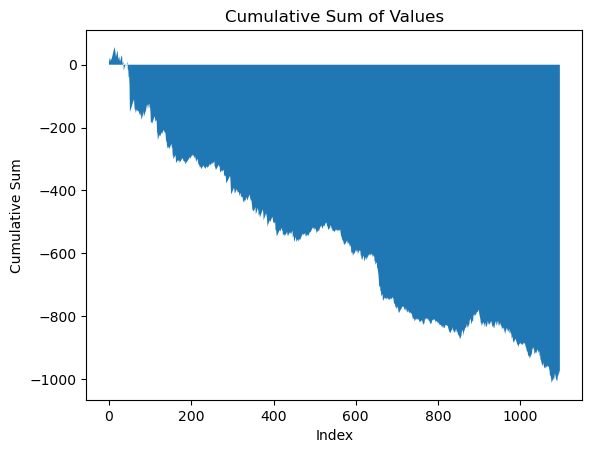

[7.300581949999886, 15.12335494999997, 23.180482250000136, 10.523392249999805, 16.15423594999927, 21.74457004999912, 14.687415049999132, 20.365892999999193, 26.022707199998802, 31.66307374999889, 37.2725834499987, 42.81529329999918, 48.378637649999135, 51.09492599999974, 56.65722114999969, 46.62867114999969, 36.93876114999969, 24.84979614999962, 30.320899749999363, 35.77720444999995, 41.15741624999975, 46.492292099999496, 28.175537099998884, 16.60242209999855, 21.92416779999834, 27.26901614999835, 15.973121149998482, 9.929076149998572, 14.999730299998737, 20.04726179999894, 25.09472334999894, 30.130024049998735, 26.068594049998705, 1.6653040499984861, 6.546320549998073, 11.342120999998158, -18.152114000001966, -13.576298450001868, -9.009666000001722, -4.471752000001453, 0.1040035999983191, 4.580843449998344, -4.827126550001527, -0.21606745000183825, 4.420792299998254, 9.009348299998091, -18.656796700001625, -14.28792580000168, -41.09698080000163, -36.86816480000149, -63.010229800001596

In [15]:
cumulative_values = []
cumulative_sum = 0
for value in agg_amts:
    cumulative_sum -= value
    cumulative_values.append(cumulative_sum)

plt.fill_between(range(len(cumulative_values)), cumulative_values, 0)

plt.xlabel('Index')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Sum of Values')

plt.show()

print(cumulative_values)

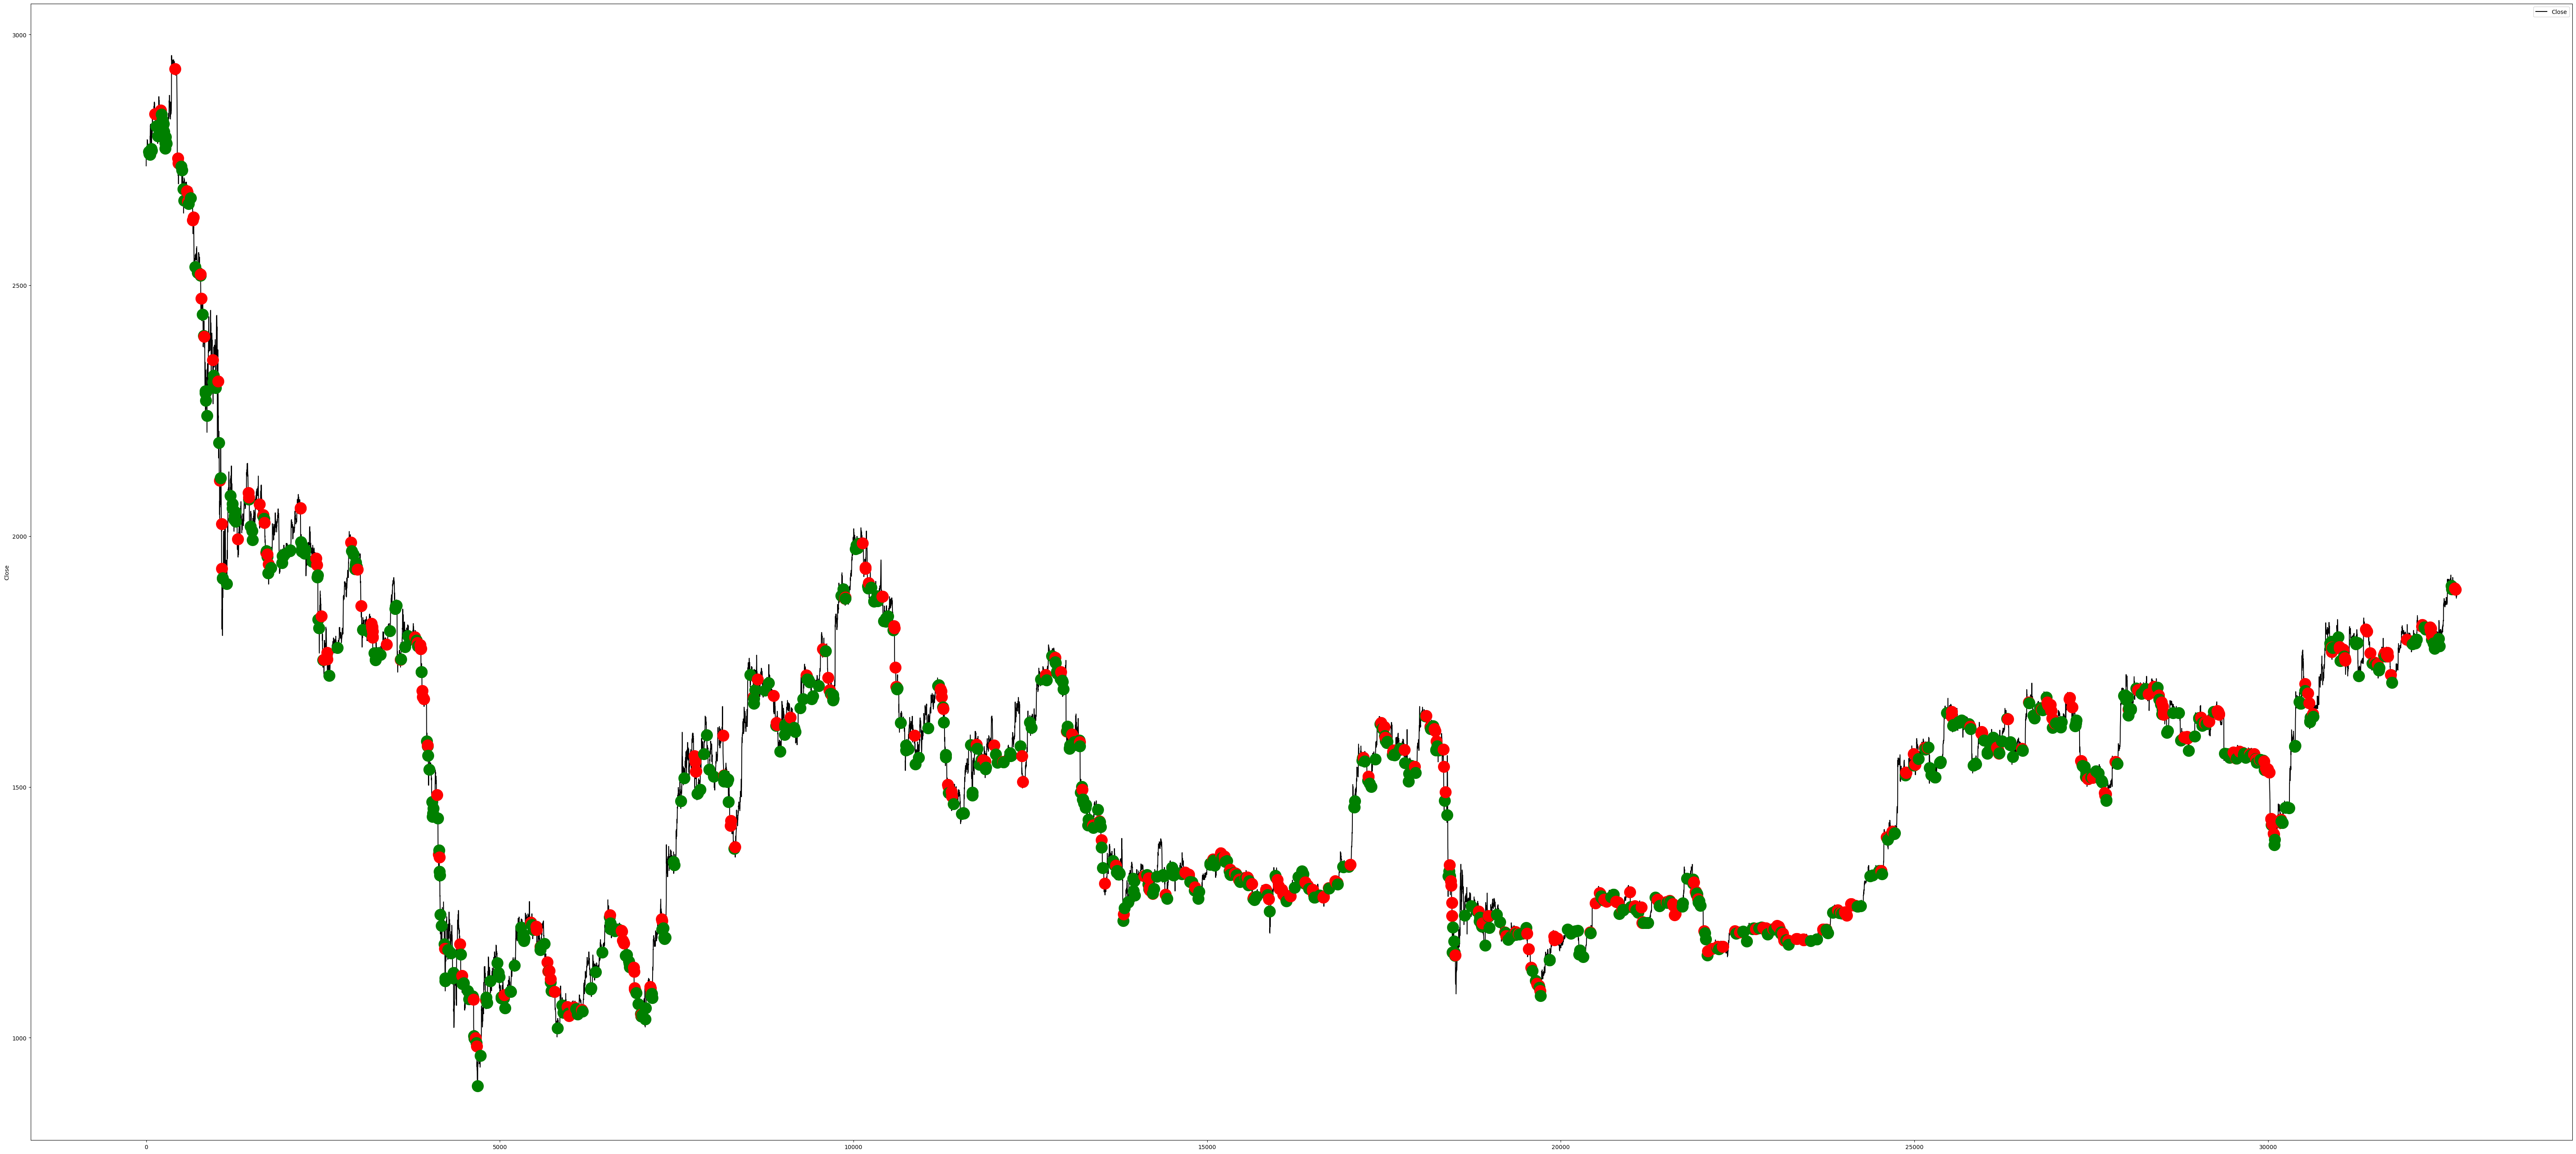

In [16]:
plt_df = raw_entry_df.copy()

plt.figure(figsize=(80, 36))
plt.ylabel('Close')
plt.plot(plt_df.Close, label = 'Close', c ='black')

i = 0
while i < len(plt_df):
    if pd.isna(plt_df.position[i]):
        i += 1
    elif plt_df.position[i] == 'Buy':
        j = i + 1
        while j < len(plt_df) and (pd.isna(plt_df.position[j]) or plt_df.position[j] == 'Buy'):
            j += 1
        if j < len(plt_df) and plt_df.position[j] == 'Sell':
            # Paint all previous 'Buy's green dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'go', label='_', markersize=20)
            i = j
        elif j < len(plt_df) and plt_df.position[j] == 'Stop':
            # Paint all previous 'Buy's red dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'ro', label='_', markersize=20)
            i = j + 1
        else:
            i = j
    else:
        i += 1

plt.legend()
plt.show()


# 之所以出現大量紅點，原因為：連續加倉會調整整個部位停利和停損，因此一些進倉部位會因為調高後的＂整個部位＂停損而出場，但該入場損益依舊為正
# 意思是該部位之停損已經高於許多前面部位之進場點位